# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 15, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 15,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': 15, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': False, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'CNN', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 20,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 5000,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': False,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': True,
        'n_jobs': 10,
        'use_gpu': True,
        'gpu_numbers': '3',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 


import warnings

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.4.1'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/lib/cuda-10.1'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 816
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  12255


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_12255_drop0.25e5000b256_custom/lnets_10000_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_50000_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed: 12.1min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
33553  1373158606                   0.000                   0.000   
9427   1373158606                   0.000                   0.000   
199    1373158606                   0.000                   0.000   
12447  1373158606                   0.000                   0.000   
39489  1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                  -0.661   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.0

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  300000000000000-target  210000000000000-target  \
count      10000.000               10000.000               10000.000   
mean  1373158606.000                  -0.000                  -0.001   
std            0.000                   0.073                   0.077   
min   1373158606.000                  -0.993                  -0.995   
25%   1373158606.000                   0.000                   0.000   
50%   1373158606.000                   0.000                   0.000   
75%   1373158606.000                   0.000                   0.000   
max   1373158606.000                   0.987                   0.995   

       201000000000000-target  200100000000000-target  200010000000000-target  \
count               10000.000               10000.000               10000.000   
mean                    0.000                  -0.000                   0.000   
std                     0.075                   0.069                   0.074   
min                    -0.983                  -0.958                  -0.966   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.995                   0.986                   0.994   

       200001000000000-target  200000100000000-target  200000010000000-target  \
count               10000.000               10000.000               10000.000   
mean                   -0.000                  -0.001                  -0.001   
std                     0.081                   0.081                   0.088   
min                    -0.993                  -0.995                  -0.978   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.997                   0.987                   0.999   

       200000001000000-target  200000000100000-target  200000000010000-target  \
count               10000.000               10000.000               10000.000   
mean                   -0.000                   0.000                  -0.001   
std                     0.073                   0.074                   0.081   
min                    -0.999                  -0.992                  -0.994   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.949                   0.964                   0.996   

       200000000001000-target  200000000000100-target  200000000000010-target  \
count               10000.000               10000.000               10000.000   
mean                    0.001                  -0.001                  -0.001   
std                     0.070                   0.084                   0.077   
min                    -1.000                  -0.998                  -0.997   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.983                   0.995                   0.997   

       200000000000001-target  200000000000000-target  120000000000000-target  \
count               10000.000               10000.000               10000.000   
mean                    0.000                  -0.001                   0.001   
std                     0.075                   0.084                   0.074   
min                    -0.986                  -0.995                  -0.946   
25%                     0.000             

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.2292044 , 0.56960675, 0.68689446, 0.21639489, 0.49407222,
        0.99078087, 0.68047886, 0.78047112, 0.79867532, 0.96161066,
        0.57085701, 0.83541232, 0.33916998, 0.60158293, 0.71407142],
       [0.28990633, 0.42156957, 0.26783951, 0.10775303, 0.04125567,
        0.73576629, 0.03247597, 0.08072352, 0.66760098, 0.78784545,
        0.49859164, 0.39266975, 0.44531162, 0.27040279, 0.97917301],
       [0.25561663, 0.22140095, 0.28632073, 0.20235375, 0.00546207,
        0.55751489, 0.32196686, 0.59936184, 0.54408885, 0.69284325,
        0.37473106, 0.02855391, 0.58081007, 0.47864835, 0.94081447],
       [0.10393615, 0.19098279, 0.69924143, 0.28782853, 0.0341106 ,
        0.50769955, 0.71021363, 0.36612969, 0.83997294, 0.63042204,
        0.68202994, 0.65913074, 0.68931647, 0.86864153, 0.49729827],
       [0.29417101, 0.63091059, 0.60079362, 0.95450761, 0.87869941,
        0.99773203, 0.20155725, 0.532914  , 0.54373491, 0.64497118,
        0.06281577, 0.83282337, 0.28907339, 

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-0.37308556],
       [-0.07261634],
       [-0.10277642],
       [-0.0809637 ],
       [ 0.23664458],
       [-0.19349866],
       [-0.29255286],
       [-0.69221777],
       [-0.28672025],
       [-0.69074321]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            _, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8910, 3725)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(990, 3725)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 3725)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
44759  1373158606                   0.000                   0.000   
25250  1373158606                   0.000                   0.000   
22860  1373158606                   0.000                   0.000   
14471  1373158606                   0.000                   0.000   
44142  1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
44759                   0.000                   0.000                   0.000   
25250                   0.000                   0.000                   0.000   
22860                   0.000                   0.000                   0.000   
14471                   0.000                   0.000                   0.000   
44142                   0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
44759                   0.000                   0.000                   0.000   
25250                   0.000                   0.000                   0.000   
22860                   0.000                   0.000                   0.000   
14471                   0.000                   0.000                   0.000   
44142                   0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
44759                   0.000                   0.000                   0.000   
25250                   0.000                   0.000                   0.000   
22860                   0.000                   0.000                   0.000   
14471                   0.000                   0.000                   0.000   
44142                   0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
44759                   0.000                   0.000                   0.000   
25250                   0.000                   0.000                   0.000   
22860                   0.000                   0.000                   0.000   
14471                   0.000                   0.000                   0.000   
44142                   0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
44759                   0.000                   0.000                   0.000   
25250                   0.000                   0.000                   0.000   
22860                   0.000                   0.000                   0.000   
14471                   0.000                   0.000                   0.000   
44142                   0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
44759                   0.000                   0.000                   0.000   
25250                   0.000                   0.000                   0.000   
22860                   0.000                   0.000                   0.000   
14471                   0.000                   0.000                   0.000   
44142                   0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
44759                   0.000                   0.000                   0.000   
25250                   0.000                   0.000                   0.000   
22860                   0.000                   0.000                   0.000   
14471                   0.000                   0.000                   0.000   
44142                   0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
44759                   0.000                   0.000                   0.000   
25250                   0.0

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
35627  1373158606                   0.000                   0.000   
15838  1373158606                   0.000                   0.000   
37218  1373158606                   0.000                   0.000   
36762  1373158606                   0.000                   0.000   
2830   1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
35627                   0.000                   0.000                   0.000   
15838                   0.000                   0.000                   0.000   
37218                   0.000                   0.000                   0.000   
36762                   0.000                   0.000                   0.000   
2830                    0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
35627                   0.000                   0.000                   0.000   
15838                   0.000                   0.000                   0.000   
37218                   0.000                   0.000                   0.000   
36762                   0.000                   0.000                   0.000   
2830                    0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
35627                   0.000                   0.000                   0.000   
15838                   0.000                   0.000                   0.000   
37218                   0.000                   0.000                   0.000   
36762                   0.000                   0.000                   0.000   
2830                    0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
35627                   0.000                   0.000                   0.000   
15838                   0.000                   0.000                   0.000   
37218                   0.000                   0.000                   0.000   
36762                   0.000                   0.000                   0.000   
2830                    0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
35627                   0.000                   0.000                   0.000   
15838                   0.000                   0.000                   0.000   
37218                   0.000                   0.000                   0.000   
36762                   0.000                   0.000                   0.000   
2830                    0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
35627                   0.000                   0.000                   0.000   
15838                   0.000                   0.000                   0.000   
37218                   0.000                   0.000                   0.000   
36762                   0.000                   0.268                   0.000   
2830                    0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
35627                   0.000                   0.000                   0.000   
15838                   0.000                   0.000                   0.000   
37218                   0.000                   0.000                   0.000   
36762                   0.000                   0.000                   0.000   
2830                    0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
35627                   0.000                   0.000                   0.000   
15838                   0.0

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
25056  1373158606                   0.000                   0.000   
30334  1373158606                   0.000                   0.000   
17962  1373158606                   0.000                   0.000   
39588  1373158606                   0.000                   0.000   
34107  1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
25056                   0.000                   0.000                   0.000   
30334                   0.000                   0.000                   0.000   
17962                   0.000                   0.000                   0.000   
39588                   0.000                   0.000                   0.000   
34107                   0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
25056                   0.000                   0.000                   0.000   
30334                   0.000                   0.000                   0.000   
17962                   0.000                   0.000                   0.000   
39588                   0.000                   0.000                   0.000   
34107                   0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
25056                   0.000                   0.000                   0.000   
30334                   0.685                   0.000                   0.000   
17962                   0.000                   0.000                   0.000   
39588                   0.000                   0.000                   0.000   
34107                   0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
25056                   0.000                   0.000                   0.000   
30334                   0.000                   0.000                   0.000   
17962                   0.000                   0.929                   0.000   
39588                   0.000                   0.000                   0.000   
34107                   0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
25056                   0.000                   0.000                   0.000   
30334                   0.000                   0.000                   0.000   
17962                   0.000                   0.000                   0.000   
39588                   0.000                   0.000                   0.000   
34107                   0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
25056                   0.000                   0.000                  -0.068   
30334                   0.000                   0.000                   0.000   
17962                   0.000                   0.000                   0.000   
39588                   0.000                   0.000                   0.685   
34107                   0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
25056                   0.000                   0.000                   0.000   
30334                   0.000                   0.000                   0.000   
17962                   0.000                  -0.165                   0.000   
39588                   0.000                   0.000                   0.000   
34107                   0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
25056                   0.000                   0.000                   0.000   
30334                   0.0

## Interpretation Network Training

In [23]:
#%load_ext autoreload

In [24]:
#%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



Trial 20 Complete [01h 46m 32s]
val_loss: 0.30422940850257874

Best val_loss So Far: 0.27271825075149536
Total elapsed time: 12h 44m 02s
Training Time: 36:46:24
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00


In [25]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  


for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)


In [26]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred


end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [27]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [28]:
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [29]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [30]:
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

In [31]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [32]:
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


False


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
Exit <class 'KeyError'>
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:15
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.7s finished


In [33]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []

for function_values_test, polynomial_dict_test in zip(function_values_test_list, polynomial_dict_test_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_target_polynomials_VS_inet_polynomials
Score Calculation Time: 0:00:01
---------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------


In [34]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [35]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/separable: True
conv_block_1/max_pooling: True
conv_block_1/dropout: 0
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 1
conv_block_1/filters_0_0: 32
conv_block_1/filters_0_1: 32
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_1: 32
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 2
dense_block_1/units_0: 32
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
optimizer: adam
learning_rate: 0.001
conv_block_1/filters_2_0: 128
conv_block_1/filters_2_1: 128
Score: 0.27271825075149536
None
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/separable: True
conv_block_1/max_pooling: True
conv_block_1/dropout: 0
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/filters_0_0: 32
conv_block_1/filters_0_1: 32
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_1: 32
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 2
dense_block_1/units_0: 32
dense_block_1/

In [36]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 1125)]    0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 4, 1125)      0           input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 4, 32)        39407       cast_to_float32[0][0]            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 2, 32)        0           separable_conv1d[0][0]           
______________________________________________________________________________________________

In [37]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [38]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.083 0.113  7.720   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  0.000   
target_polynomials_VS_inet_polynomials             0.238 0.319 23.129   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.083 0.113  1.955   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.250 0.330 24.901   
lstsq_target_polynomials_VS_inet_polynomials       0.238 0.319 23.129   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.391   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.152   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.391   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.151   
lstsq_target_polynomials_VS_inet_polynomials           0.152   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.046    0.060    0.878   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.064    0.083    1.440   
lambda_preds_VS_lstsq_target_polynomials             0.046    0.060    0.878   
lambda_preds_VS_inet_polynomials                     0.274    0.348    4.400   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.064    0.084    1.482   
target_polynomials_VS_lstsq_target_polynomials       0.000    0.000    0.000   
target_polynomials_VS_inet_polynomials               0.276    0.357    3.821   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.064    0.084    2.141   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    0.281    0.360    4.873   
lstsq_target_polynomials_VS_inet_polynomials         0.276    0.357    3.835   

                                                    R2 FV  RAAE FV  RMAE FV  \
lambda_preds_VS_target_polynomials                  0.974    0.120    0.769   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.951    0.169    0.913   
lambda_preds_VS_lstsq_target_polynomials            0.974    0.120    0.769   
lambda_preds_VS_inet_polynomials                    0.170    0.711    2.929   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.953    0.165    0.902   
target_polynomials_VS_lstsq_target_polynomials      1.000    0.000    0.000   
target_polynomials_VS_inet_polynomials              0.173    0.699    3.181   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.953    0.164    0.893   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.165    0.708    3.198   
lstsq_target_polynomials_VS_inet_polynomials   

In [39]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.047 0.056 0.039 0.044   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.065 0.081 0.056 0.059   
lambda_preds_VS_lstsq_target_polynomials           0.047 0.056 0.039 0.044   
lambda_preds_VS_inet_polynomials                   0.287 0.402 0.171 0.238   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.065 0.081 0.054 0.059   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.291 0.400 0.172 0.240   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.065 0.081 0.054 0.059   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.295 0.407 0.179 0.249   
lstsq_target_polynomials_VS_inet_polynomials       0.291 0.400 0.172 0.240   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.041 0.065 0.031 0.059   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.062 0.086 0.055 0.066   
lambda_preds_VS_lstsq_target_polynomials           0.041 0.065 0.031 0.059   
lambda_preds_VS_inet_polynomials                   0.292 0.336 0.265 0.245   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.059 0.087 0.051 0.075   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.295 0.343 0.266 0.245   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.059 0.087 0.051 0.075   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.301 0.355 0.273 0.253   
lstsq_target_polynomials_VS_inet_polynomials       0.295 0.343 0.266 0.245   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.046 0.043 0.053 0.040   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.057 0.067 0.073 0.062   
lambda_preds_VS_lstsq_target_polynomials           0.046 0.043 0.053 0.040   
lambda_preds_VS_inet_polynomials                   0.240 0.312 0.290 0.365   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.059 0.063 0.072 0.059   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.239 0.314 0.295 0.367   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.059 0.063 0.072 0.059   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.247 0.319 0.300 0.371   
lstsq_target_polynomials_VS_inet_polynomials       0.239 0.314 0.295 0.367   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.046 0.049 0.054 0.042   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.069 0.067 0.072 0.052   
lambda_preds_VS_lstsq_target_polynomials           0.046 0.049 0.054 0.042   
lambda_preds_VS_inet_polynomials                   0.265 0.239 0.261 0.179   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.068 0.072 0.074 0.057   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.270 0.238 0.265 0.181   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.068 0.072 0.074 0.057   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.273 0.242 0.270 0.183   
lstsq_target_polynomials_VS_inet_polynomials       0.270 0.238 0.265 0.181   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.045 0.056 0.040 0.051   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.055 0.075 0.061 0.055   
lambda_preds_VS_lstsq_target_polynomials           0.045 0.056 0.040 0.051   
lambda_preds_VS_inet_polynomials                   0.255 0.284 0.247 0.231   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.061 0.075 0.059 0.061   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.258 0.286 0.250 0.

In [40]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'].values

array([ 0.18218764,  0.256193  ,  0.26758887,  0.12616455,  0.1213095 ,
        0.43284498, -0.15707473,  0.39516864,  0.17012366,  0.17184458,
        0.2902772 ,  0.15665816,  0.43653898,  0.36591579,  0.17320656,
        0.07901633,  0.21951731,  0.34285741,  0.16490484,  0.17735177,
        0.2639011 ,  0.18465244,  0.15498647,  0.25992275,  0.46048716,
        0.31642899,  0.02987791, -0.33184046, -1.36819014,  0.19520031,
       -0.06023887,  0.35712204, -0.03441386,  0.2888862 ,  0.01386954,
        0.18403596,  0.38797206,  0.51639542,  0.26273949,  0.21061767,
       -0.13311384,  0.386045  ,  0.29732388,  0.02309177,  0.0865243 ,
        0.09377247,  0.26183455,  0.23056509,  0.23334433,  0.21388862,
        0.56082266,  0.19998498,  0.15404217,  0.53692381,  0.28482599,
        0.04844847,  0.38395094,  0.39413535,  0.17637451,  0.12377851,
        0.12040853,  0.33151527, -0.10323703,  0.01153107,  0.01797452,
        0.31383116,  0.1437468 ,  0.27091044,  0.20819804,  0.22

In [41]:
distrib_dict_test_list[-1]['R2']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.979 0.983 0.960 0.967   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.962 0.969 0.923 0.943   
lambda_preds_VS_lstsq_target_polynomials           0.979 0.983 0.960 0.967   
lambda_preds_VS_inet_polynomials                   0.182 0.256 0.268 0.126   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.961 0.969 0.931 0.947   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.173 0.264 0.265 0.133   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.962 0.969 0.930 0.947   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.179 0.254 0.231 0.122   
lstsq_target_polynomials_VS_inet_polynomials       0.173 0.264 0.265 0.133   

                                                     L-4   L-5    L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.982 0.977  0.983 0.960   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.959 0.960  0.949 0.954   
lambda_preds_VS_lstsq_target_polynomials           0.982 0.977  0.983 0.960   
lambda_preds_VS_inet_polynomials                   0.121 0.433 -0.157 0.395   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.964 0.961  0.956 0.943   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000  1.000 1.000   
target_polynomials_VS_inet_polynomials             0.121 0.428 -0.138 0.408   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.965 0.962  0.958 0.943   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.122 0.408 -0.150 0.383   
lstsq_target_polynomials_VS_inet_polynomials       0.121 0.428 -0.138 0.408   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.969 0.983 0.976 0.989   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.953 0.960 0.954 0.973   
lambda_preds_VS_lstsq_target_polynomials           0.969 0.983 0.976 0.989   
lambda_preds_VS_inet_polynomials                   0.170 0.172 0.290 0.157   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.950 0.964 0.959 0.975   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.165 0.178 0.284 0.169   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.952 0.965 0.959 0.975   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.161 0.160 0.285 0.129   
lstsq_target_polynomials_VS_inet_polynomials       0.165 0.178 0.284 0.169   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.981 0.972 0.962 0.945   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.961 0.948 0.934 0.914   
lambda_preds_VS_lstsq_target_polynomials           0.981 0.972 0.962 0.945   
lambda_preds_VS_inet_polynomials                   0.437 0.366 0.173 0.079   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.963 0.941 0.933 0.904   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.439 0.361 0.165 0.091   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.963 0.941 0.933 0.902   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.427 0.359 0.149 0.071   
lstsq_target_polynomials_VS_inet_polynomials       0.439 0.361 0.165 0.091   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.974 0.973 0.975 0.959   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.963 0.951 0.950 0.952   
lambda_preds_VS_lstsq_target_polynomials           0.974 0.973 0.975 0.959   
lambda_preds_VS_inet_polynomials                   0.220 0.343 0.165 0.177   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.958 0.954 0.954 0.943   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.213 0.3

In [42]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9140500490930037


-0.007634135419547*a**3 + 0.072958982860742*a**2*b - 0.061597449297901*a**2*c - 0.0804759909203343*a**2*d - 0.002758446118792*a**2*e + 0.0284503149508996*a**2*f + 0.0968202321407397*a**2*g - 0.0492846111900486*a**2*h + 0.0761914111117462*a**2*i + 0.137907364299451*a**2*j + 0.0218974485644451*a**2*k + 0.0417971051209517*a**2*l - 0.0471012062868961*a**2*m + 0.0724019844398404*a**2*n + 0.0588673890318341*a**2*o - 0.168946557043634*a**2 - 0.0848446379119602*a*b**2 + 0.145022405952753*a*b*c - 0.0724374755877491*a*b*d - 0.0579256630507443*a*b*e - 0.102008564553695*a*b*f - 0.0193634253196125*a*b*g - 0.0769945225319327*a*b*h + 0.0607732454973614*a*b*i - 0.110221281983399*a*b*j + 0.155806774428134*a*b*k + 0.0386236692012252*a*b*l - 0.0285270903946957*a*b*m - 0.108740910743317*a*b*n + 0.0610774698613444*a*b*o + 0.0780332364417207*a*b + 0.0408557038188988*a*c**2 + 0.099145110138907*a*c*d - 0.0922084196536914*a*c*e - 0.0584465166505307*a*c*f - 0.162357723563992*a*c*g - 0.0374059455315293*a*c*h + 0

In [43]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.17011278963620452 (100 Samples)
Mean (only positive): 0.22561109374802388 (88 Samples)


In [44]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9510382607110194 (100 Samples)
Mean (only positive): 0.9510382607110194 (100 Samples)


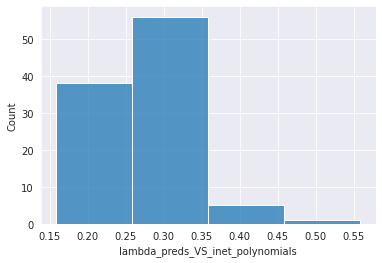

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

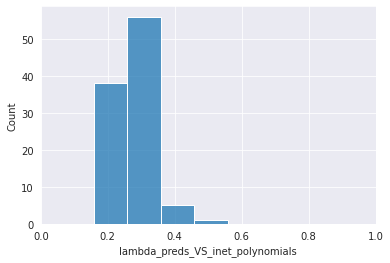

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


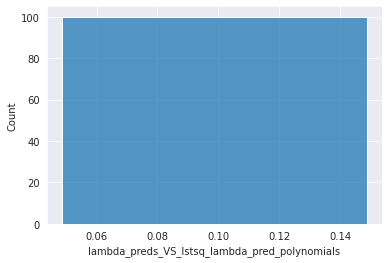

In [47]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

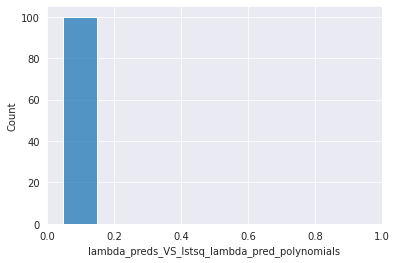

In [48]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


In [49]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [50]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [52]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [53]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [54]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


-0.0888*a**3 - 0.0571*a**2*b + 0.0343*a**2*c + 0.0956*a**2*d + 0.0721*a**2*e - 0.1028*a**2*f + 0.0412*a**2*g - 0.0038*a**2*h + 0.2204*a**2*i - 0.1508*a**2*j + 0.0408*a**2*k - 0.0322*a**2*l + 0.1109*a**2*m + 0.0439*a**2*n + 0.0198*a**2*o + 0.0328*a**2 + 0.1814*a*b**2 + 0.1109*a*b*c + 0.0202*a*b*d + 0.0573*a*b*e - 0.0735*a*b*f + 0.1346*a*b*g - 0.1323*a*b*h + 0.0112*a*b*i + 0.0822*a*b*j - 0.1065*a*b*k - 0.0653*a*b*l - 0.1179*a*b*m + 0.1303*a*b*n - 0.0513*a*b*o - 0.1577*a*b - 0.0303*a*c**2 + 0.0342*a*c*d + 0.0664*a*c*e - 0.0759*a*c*f - 0.0853*a*c*g - 0.0138*a*c*h - 0.0186*a*c*i + 0.0375*a*c*j - 0.0606*a*c*k + 0.07*a*c*l + 0.0476*a*c*m - 0.0567*a*c*n + 0.1075*a*c*o - 0.0827*a*c + 0.0575*a*d**2 - 0.0668*a*d*e + 0.0298*a*d*f - 0.0481*a*d*g - 0.08*a*d*h + 0.0054*a*d*i - 0.1422*a*d*j + 0.0318*a*d*k + 0.0052*a*d*l - 0.0163*a*d*m + 0.0851*a*d*n - 0.057*a*d*o - 0.0816*a*d + 0.4384*a*e**2 - 0.0731*a*e*f - 0.2385*a*e*g + 0.116*a*e*h - 0.2088*a*e*i + 0.1062*a*e*j - 0.0931*a*e*k - 0.0164*a*e*l - 0.049

[-8.87749482e-02 -5.70983585e-02  3.43383801e-02  9.55734489e-02
  7.21122718e-02 -1.02812419e-01  4.12260526e-02 -3.79426961e-03
  2.20418656e-01 -1.50846032e-01  4.07741350e-02 -3.21987309e-02
  1.10869691e-01  4.39093895e-02  1.97838580e-02  3.27717240e-02
  1.81446537e-01  1.10942430e-01  2.02088509e-02  5.72637936e-02
 -7.35187000e-02  1.34649197e-01 -1.32341294e-01  1.11814036e-02
  8.21871828e-02 -1.06476652e-01 -6.52645623e-02 -1.17894067e-01
  1.30264060e-01 -5.12859060e-02 -1.57693013e-01 -3.03125914e-02
  3.42427997e-02  6.63891897e-02 -7.59377848e-02 -8.53037653e-02
 -1.38138384e-02 -1.86174363e-02  3.74950633e-02 -6.06177190e-02
  7.00319919e-02  4.75908153e-02 -5.67169066e-02  1.07506625e-01
 -8.26875070e-02  5.75412368e-02 -6.68213187e-02  2.97623098e-02
 -4.81490622e-02 -7.99968391e-02  5.41206594e-03 -1.42222227e-01
  3.18315685e-02  5.21674812e-03 -1.63489050e-02  8.51141187e-02
 -5.69976748e-02 -8.15860187e-02  4.38431707e-01 -7.31126434e-02
 -2.38516780e-01  1.16039

0.9151*a*e**2 + 0.0815*a*f*k - 0.6348*a*f + 0.1193*a*i*j - 0.2457*a*k*l - 0.7464*a*k + 0.2547*b*g + 0.2887*b*l*m - 0.6018*c*d*j - 0.0859*d*k*o - 0.3916*e*g**2 + 0.7203*e*j*k - 0.6148*i*k + 0.0183*i - 0.0644*j**2*m

[ 5.16953662e-08  3.15982362e-08  4.95938075e-08 -3.70415946e-08
 -2.12840097e-08 -1.00619384e-07  4.93762343e-08 -4.02898943e-08
 -3.45879135e-08 -1.05695747e-08 -3.90992373e-08  5.45817378e-08
 -1.51596006e-08  8.58486640e-08  6.33957428e-08 -1.06347104e-07
  1.57972243e-08  2.34493067e-08  2.70040711e-08  1.43638883e-08
 -6.85203072e-09 -1.15442095e-08  1.82896685e-08 -7.19283984e-08
  2.52298714e-08  7.64387904e-09 -3.15986582e-08  9.68635949e-09
 -2.68285796e-09 -1.16093522e-08 -4.39082077e-08  2.13070666e-08
 -1.13467709e-08  3.24253823e-08 -8.89896567e-08  1.81659128e-08
  1.29797102e-08 -6.87724379e-09  6.14999674e-08  6.38035076e-08
  3.31825654e-08  7.19559917e-08 -3.00762205e-08  5.65433860e-08
 -1.77449410e-07  1.77796264e-08  1.35796675e-08 -4.06472320e-08
  5.44349053e-09  6.19424634e-09 -2.30038654e-08 -4.03327576e-08
  3.51922557e-08  3.37811837e-08 -8.42268172e-09  3.45749742e-08
 -7.72323287e-09  1.44687067e-08  9.15064862e-01  2.80568010e-09
  4.90851970e-08  3.07586

0.9151*a*e**2 + 0.0815*a*f*k - 0.6348*a*f + 0.1193*a*i*j - 0.2457*a*k*l - 0.7464*a*k + 0.2547*b*g + 0.2887*b*l*m - 0.6018*c*d*j - 0.0859*d*k*o - 0.3916*e*g**2 + 0.7203*e*j*k - 0.6148*i*k + 0.0183*i - 0.0644*j**2*m

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.91506488  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.08146589  0.          0.
  0.          0.         -0.63478446  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

-0.508400022983551*a*c*g - 0.163200005888939*b*c**2 + 0.133499994874001*b*l**2 - 0.315600007772446*c*g - 0.109099999070168*c*i*j + 0.142900004982948*d*e*i - 0.408199995756149*d*f**2 - 0.107600003480911*e*l*n - 0.155000001192093*f**3 - 0.261999994516373*f*m**2 - 0.0899000018835068*g**2*i - 0.305500000715256*h*i**2 + 0.188500002026558*i*j**2 - 0.250999987125397*i*l*m - 0.192800000309944*i*m*n

[ 0.18853901 -0.10760927 -0.19277738 ...  0.00107744  0.00144015
  0.00122302]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


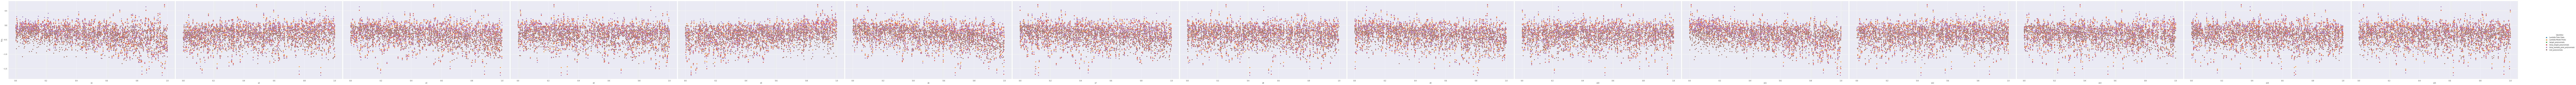

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

In [56]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

LinAlgError: Singular matrix

ValueError: 'bboxes' cannot be empty

<Figure size 0x0 with 256 Axes>

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [ ]:
STOP

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()